## Chapter 6: Going Viral! Information Diffusion  

### Anatomy of a Viral Video  

If you post a video to YT or Instagram, the only people that see it at first are in your immediate *ego network* -- ie, your friends. Growth is slow and linear over time, meaning that views happen at a constant rate. In this case, we can describe the number of views as a Poisson process, where every act of viewing your cat video is independent of every other act. At the end, the total number of views you would get would be mathematically related to the number of followers you have -- your *degree centrality*. 

#### What did Facebook Do Right? 

The rule that facebook followed -- and what made it different -- was to achieve saturation within a community before moving to a larger community. This way, critical mass was never lost and new members folded neatly into the social structure set up by their peers from other schools.  

#### How Do You Estimate Critical Mass? 

If the transition from linear propogation to exponential growth indeed depends on triadic closure (ie, friend of a friend is my friend) then the critical mass of connections can be estimated by measuring the probability that a randomly created link from *A* to *B* will form one or more open triads with other nodes. This is proportional to the number of nodes already connected (we double the number of nodes because each tie involves 2 nodes):  

*P(open_triad) ~= #ties/(2 * nodes)*  

Thus, probability of an open triad reaches 50% when a quarter of the nodes are connected -- and every new connection causes the triadic closure rules to create even more connections, further increasing the probability of a cascade. 

In experiments, we've found that the transition from linear growth (where connections are added one by one) to going viral happens somewhere around 7% density -- ie, if 7% of people in the intended audience adopt a meme, retweet a video, join a site, etc, the rest will floow shortly in a viral wave. 

#### Wikinomics of Critical Mass  

There is one more consideration to the critical mass question -- the idea of cost participation.

Critical mass will be reached when the benefits of using the product start outweighing the cost; at this point, each connection will in turn breed more connections, further increasing the benefit--while the cost remains constant. 

If the cost/benefit crossover is never reached, eventually the network will fail.   

#### Content is (Still) King  

If content is compelling, this raises the benefit and makes the cost-benefit crossover happen sooner, thus shifting critical mass of connections down from 7% to 3% or 4%. If the content quality is not very good, however, critical mass may not be reached at all. 

### How Does Information Shape Networks (and Vice Versa)?  

Information, ideas, and views can change relatively rapidly, and in doing so, shape network structures. At the same time, the shape of networks controls where information can spread. As a result, we have a double feedback loop where social structure influences information transmission, and information influences change in social structure.

#### Birds of a Feather?   

In *Theory of 2-mode networks* we introduces **homophily**, creation of links between nodes as a function of how similar they are. This is distinguishied into two types:

**Status homophily** individuals of a similar social class, wealth, and status are more likely to associate with each other than by chance.

**Value homophily** is a tendency to associate with others who think in similar ways or like similar things, regardless of class and status.  

American culture has been significantly more amenable to value homophily than many other societies where one's upbringing and membership of a class often clearly and unambiguously defines what kinds of information or cultural artifacts one may be exposed to. 

#### Homophily vs. Curiousity  

While homophily remains a stron social force, a second force can be in play if the two people are not very similar but not so different as to limit their ability to find topics for conversation. This force is **curiosity or information seeking**, and as a resuilt, likelihood of connection takes a funny 2-hump shape. The heigh and location of the "curiousity hill" is different for every person and is related to our novelty-seeking or novelty avoidance tendencies.  

The final feature is the **boredom trap**. Meeting a person who is exactly the same as you in every aspect provides no new information or stimulation -- thus, the likelihood of connection drops off dramatically. The location and severity of the boredom trap also differs from person to person and also appears to be related to the way our brain processes and needs novelty. 

### A Simple Dynamic Model in Python 

Let's try to model diffusion in a social network. We will build a very simple agent-based model in which agents can influence each other and reach a consensus (if such is possible) within their social network. 

This model was originally proposed by Noah Friedkin in 1998. The model follows a very simple premise: everyone comes into a discussion with their own take on the problem (or their own attitude), and everybody accepts influence from their friends in the network, to a degree. Let us also make an assumption that the information that our agents will be exchanging is about a single real number between 0 and 1. This could mean the likelihood of the stock market going up, or possibly the likelihood of an agent trying an illegal drug. 

Let us set our simple model. We are not going to use an agent-based modeling toolkit, or a simulation toolkit. 

Let's start by defining a Python class for a person:

In [13]:
import networkx as net
import random as r
import matplotlib.pyplot as plt
%matplotlib inline

class Person(object):
    
    def __init__(self, id):
        # Start with a single initial preference
        self.id = id
        self.i = r.random() #initial attitude
        self.a = self.i # acquired attitude
        # we value initial opinion and subsequent information equally
        self.alpha = 0.8
        
    def __str__(self):
        return(str(self.id))

A *Person* has an ID, and 3 important numbers: `self.i` is an initial attitude, `self.a` is an acquired attitude, and `self.alpha` is what we will call the "gullibility factor" (ie, the higher the alpha, the more likely I am to trust my friends opinions and distrust my initial knowledge_. For the sake of the initial approach, let's assume that everyone is gullible to exactly the same degree. 

Now let's create a network of *Person* nodes. NetworkX allows us to use any object as a graph node, we'll use this feature:

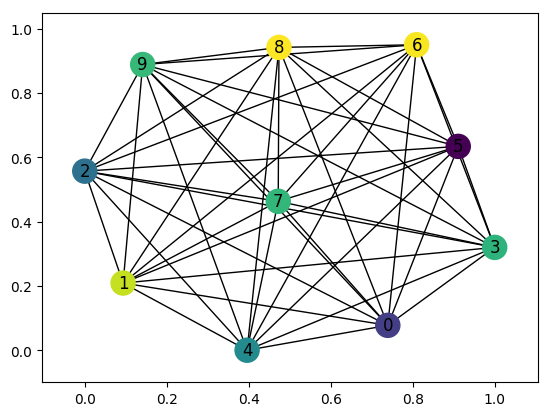

In [18]:
density = 0.9
g = net.Graph()

# create a network of Person objects
for i in range(10):
    p = Person(i)
    g.add_node(p)
    
## this will be a simple reandom graph, every pair of nodes has an equal probability of connection 
for x in g.nodes():
    for y in g.nodes():
        if r.random() <= density:
            g.add_edge(x, y)
            
## draw the resulting graph and color the nodes by their value 
col = [n.a for n in g.nodes()]
pos = net.spring_layout(g)
net.draw_networkx(g, pos=pos, node_color=col);

First, we initialize an empty graph and add 10 objects of type *Person* to the graph. Then we iterate through every possible combination of 2 nodes. With probability equal to the *density* parameter, we shall add an edge between 2 nodes. This kind of graph generation is called an **Erdos-Renyi algorithm**; it is the simplest way to generate a random graph, and results in a normally distributed degree centrality. 

Erdos-Renyi random graphs have been used as a benchmark for many graph-based algorithms and models, but now we know that they are quite unrealistic as a representation of a social network, because most social networks have a long-tail distribution of degrees (eg, power-law). However, since other methods for generating networks are significantly more complex, and beyond the scope of this model, we'll use the simplest tool available.

Now the preliminaries are set up, let's create the simulation itself. Insert the following function into the `Person` class:

In [17]:
class Person(object):
    
    def __init__(self, id):
        # Start with a single initial preference
        self.id = id
        self.i = r.random() #initial attitude
        self.a = self.i # acquired attitude
        # we value initial opinion and subsequent information equally
        self.alpha = 0.8
        
    def step(self):
        #loop through the neighbors and aggregate their preferences
        neighbors=g[self]
        #all nodes in the list of neighbors are equally weighted, including self
        w=1/float((len(neighbors)+1))
        s=w*self.a
        for node in neighbors:
            s+=w*node.a

        # update my beliefs = initial belief plus sum of all influences
        self.a=(1-self.alpha)*self.i + self.alpha*s
        
    def __str__(self):
        return(str(self.id))

This function updates a Person's attitude (a) based on a weighted sum of her friends attitudes, and the person's gullibility factor *alpha*. First, we'll compute the weights. For the sake of simplicity, everyone's opinion is weighted equally. 

Then we compute a weighted sum of the Person's own opinion, and everyone else's opinions. Finally, we update the current opinion by saying that a Person's opinion at time *t* equals the objective knowledge multiplied by the gullibility factor, added to the weighted sum of their friends opinions. 

Finally, we run this in a loop to see how the network changes over time:

[0.5475093469581868, 0.916570085569781, 0.45288322577878226, 0.6910290040204148, 0.5435025080473164, 0.1380643023791136, 0.9851986631170099, 0.7016597547143988, 0.9922660825929666, 0.7087929909941127]
[0.5475093469581868, 0.7356082752770008, 0.45288322577878226, 0.6910290040204148, 0.5435025080473164, 0.1380643023791136, 0.9851986631170099, 0.7016597547143988, 0.9922660825929666, 0.7087929909941127]
[0.5475093469581868, 0.7356082752770008, 0.5959873636763445, 0.6910290040204148, 0.5435025080473164, 0.1380643023791136, 0.9851986631170099, 0.7016597547143988, 0.9922660825929666, 0.7087929909941127]
[0.5475093469581868, 0.7356082752770008, 0.5959873636763445, 0.6713437859529761, 0.5435025080473164, 0.1380643023791136, 0.9851986631170099, 0.7016597547143988, 0.9922660825929666, 0.7087929909941127]
[0.5475093469581868, 0.7356082752770008, 0.5959873636763445, 0.6713437859529761, 0.6296776348281354, 0.1380643023791136, 0.9851986631170099, 0.7016597547143988, 0.9922660825929666, 0.708792990994

[0.5656661815396455, 0.6998549560606819, 0.5998345159329141, 0.6511900897461027, 0.6193617818625191, 0.5319057803267402, 0.7091932716648023, 0.6534495381021646, 0.7161216823086733, 0.6550604797548726]
[0.5656661815396455, 0.6998549560606819, 0.5998345159329141, 0.6511900897461027, 0.6193617818625191, 0.5319057803267402, 0.7091932716648023, 0.6534495381021646, 0.7161216823086733, 0.6549730532572945]
[0.5655819313016474, 0.6998549560606819, 0.5998345159329141, 0.6511900897461027, 0.6193617818625191, 0.5319057803267402, 0.7091932716648023, 0.6534495381021646, 0.7161216823086733, 0.6549730532572945]
[0.5655819313016474, 0.6997737666866268, 0.5998345159329141, 0.6511900897461027, 0.6193617818625191, 0.5319057803267402, 0.7091932716648023, 0.6534495381021646, 0.7161216823086733, 0.6549730532572945]
[0.5655819313016474, 0.6997737666866268, 0.5997562762192037, 0.6511900897461027, 0.6193617818625191, 0.5319057803267402, 0.7091932716648023, 0.6534495381021646, 0.7161216823086733, 0.6549730532572

[0.565395679521972, 0.6995942815494027, 0.5995833118880309, 0.6509489070883002, 0.6191293615194124, 0.5316818039581297, 0.7089808337150326, 0.6532414169357689, 0.715921122313156, 0.6547797797306795]
[0.565395679521972, 0.6995942815494027, 0.5995833118880309, 0.6509480120992237, 0.6191293615194124, 0.5316818039581297, 0.7089808337150326, 0.6532414169357689, 0.715921122313156, 0.6547797797306795]
[0.565395679521972, 0.6995942815494027, 0.5995833118880309, 0.6509480120992237, 0.6191284990458429, 0.5316818039581297, 0.7089808337150326, 0.6532414169357689, 0.715921122313156, 0.6547797797306795]
[0.565395679521972, 0.6995942815494027, 0.5995833118880309, 0.6509480120992237, 0.6191284990458429, 0.5316809728187587, 0.7089808337150326, 0.6532414169357689, 0.715921122313156, 0.6547797797306795]
[0.565395679521972, 0.6995942815494027, 0.5995833118880309, 0.6509480120992237, 0.6191284990458429, 0.5316809728187587, 0.7089800453928313, 0.6532414169357689, 0.715921122313156, 0.6547797797306795]
[0.56

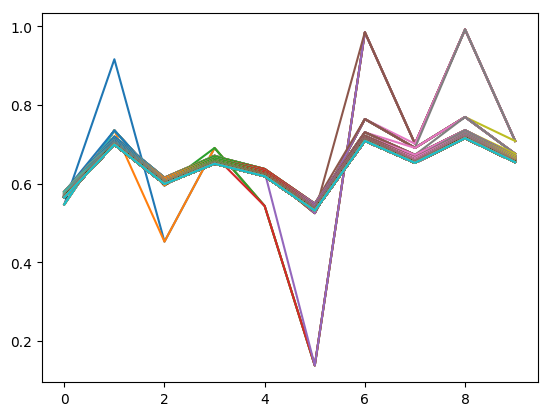

In [19]:
## repeat for 30 time periods
for i in range(30):
    ## iterate through all nodes in the network and tell them to make a step
    for node in g.nodes():
        node.step()
        
        #collect new attitude data, print it and plot it
        col = [n.a for n in g.nodes()]
        print(col)
        plt.plot(col)

## Coevolution of Networks and Information 

Now we'll modify the model of influence so that networks allow for change in the network as well as the attitudes of individuals and information content of the network. 

First, let's remove the 